In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import  xml.etree.ElementTree as ET
import cv2
import shutil
from tensorflow.keras.layers import Conv2D,BatchNormalization,LeakyReLU,Flatten,Dense,Dropout,Reshape
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)

import os

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
train_images="JPEGImages/"
train_maps="Annotations/"

classes=['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']

N_CLASSES=len(classes)
H,W=224,224
SPLIT_SIZE=int(H/32)
N_EPOCHS=135
BATCH_SIZE=32

##### WRITE FUNCTION TO EXTRACT BOUNDING BOXES FROM EACH IMAGE

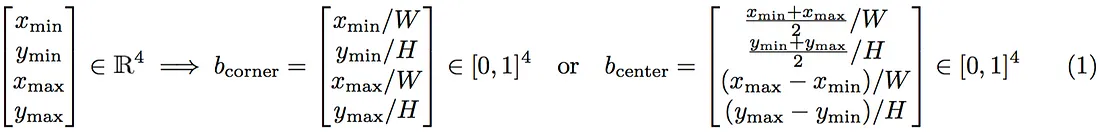

In [3]:
# This function preprocesses an XML file containing object detection annotations.
def preprocess_xml(filename):
    
    # Parse the XML file using ElementTree.
    tree = ET.parse(filename)
    root = tree.getroot()
    
    # Extract image size from the XML.
    size_tree = root.find('size')
    height = float(size_tree.find('height').text)
    width = float(size_tree.find('width').text)
    
    # Initialize list to store bounding boxes.
    bounding_boxes = []
    
    # Create a dictionary to map class names to indices.
    class_dict = {classes[i]: i for i in range(len(classes))}
    
    # Iterate through each object annotation in the XML.
    for object_tree in root.findall('object'):
        # Extract bounding box coordinates.
        for bounding_box in object_tree.iter('bndbox'):
            xmin = float(bounding_box.find('xmin').text)
            xmax = float(bounding_box.find('xmax').text)
            ymin = float(bounding_box.find('ymin').text)
            ymax = float(bounding_box.find('ymax').text)
            break
        
        # Extract class name of the object.
        class_name = object_tree.find('name').text
        
        # Calculate normalized bounding box coordinates and append to the list.
        bounding_box = [
            (xmin + xmax) / (2 * width),
            (ymin + ymax) / (2 * height),
            (xmax - xmin) / width,
            (ymax - ymin) / height,
            class_dict[class_name]
        ]
        bounding_boxes.append(bounding_box)
    
    # Convert the list of bounding boxes to a TensorFlow tensor and return.
    return tf.convert_to_tensor(bounding_boxes)

print('The bounding boxes of the following image are : \n\n',preprocess_xml(train_maps+"2007_000032.xml"))

The bounding boxes of the following image are : 

 tf.Tensor(
[[ 0.479       0.4644128   0.542       0.37366548  0.        ]
 [ 0.33        0.37544483  0.128       0.12455516  0.        ]
 [ 0.408       0.727758    0.036       0.17437722 14.        ]
 [ 0.07        0.7597865   0.036       0.17437722 14.        ]], shape=(4, 5), dtype=float32)


2024-05-13 21:45:17.494218: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-13 21:45:17.494232: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-05-13 21:45:17.494235: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-05-13 21:45:17.494259: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-13 21:45:17.494270: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


##### PLOT THE IMAGE WITH BOUNDING BOXES OBTAINED FROM THE ABOVE FUNCTION

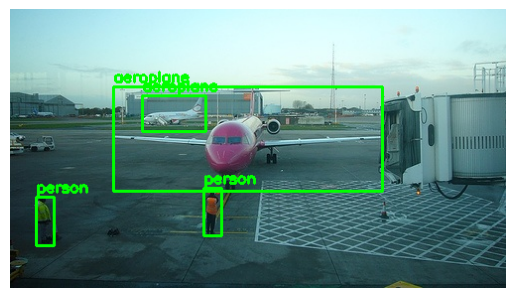

In [4]:
img_path = train_images + "2007_000032.jpg"
bounding_boxes = preprocess_xml(train_maps+"2007_000032.xml")

# Load the image using OpenCV.
image = cv2.imread(img_path)

# Iterate through the bounding boxes and plot them on the image.
for bbox in bounding_boxes:
    # Extract bounding box coordinates and class index.
    x_center, y_center, bbox_width, bbox_height, class_index = bbox
    
    # Convert normalized coordinates to absolute coordinates.
    x_min = int((x_center - bbox_width / 2) * image.shape[1])
    y_min = int((y_center - bbox_height / 2) * image.shape[0])
    x_max = int((x_center + bbox_width / 2) * image.shape[1])
    y_max = int((y_center + bbox_height / 2) * image.shape[0])
    
    # Draw bounding box rectangle on the image.
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    
    # Add class label text.
    class_name = classes[int(class_index)]
    cv2.putText(image, class_name, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)


# Show the image with bounding boxes.
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels.
plt.show()


### INITIALISING THE YOLO OUTPUT FUNCTION

1. **Initialize output label tensor**: This creates a 3D numpy array of zeros with dimensions `SPLIT_SIZE x SPLIT_SIZE x (N_CLASSES + 5)`. `SPLIT_SIZE` is the number of grid cells the image is divided into along the width and height, and `N_CLASSES` is the number of object classes. The `+ 5` accounts for the 5 parameters of the bounding box (objectness score, x, y, width, height).

2. **Calculate grid positions**: For each bounding box, it calculates the grid cell coordinates `(grid_x, grid_y)` that the center of the bounding box falls into. This is done by multiplying the normalized x and y coordinates of the bounding box center by `SPLIT_SIZE`.

3. **Convert to integer grid indices**: The floating point grid coordinates are converted to integer indices `(i, j)` which represent the row and column of the grid cell in the output tensor.

This part of the code is assigning values to the output label tensor for each bounding box:

- `output_label[i, j, 0:5] = [1., grid_x % 1, grid_y % 1, bounding_boxes[..., b, 2], bounding_boxes[..., b, 3]]`: This line is assigning the first five values for the grid cell `(i, j)`. The values are:
    1. `1.`: This is the objectness score, which indicates the presence of an object in the bounding box. It is set to 1 because there is an object in this bounding box.
    2. `grid_x % 1`: This is the x-coordinate of the center of the bounding box relative to the grid cell. It is calculated as the remainder of `grid_x` divided by 1, which gives the fractional part of `grid_x`.
    3. `grid_y % 1`: This is the y-coordinate of the center of the bounding box relative to the grid cell. It is calculated in the same way as `grid_x % 1`.
    4. `bounding_boxes[..., b, 2]`: This is the width of the bounding box, normalized by the width of the image.
    5. `bounding_boxes[..., b, 3]`: This is the height of the bounding box, normalized by the height of the image.

- `output_label[i, j, 5 + int(bounding_boxes[..., b, 4])] = 1.`: This line is assigning the class label for the object in the bounding box. The class label is represented as a one-hot vector, 

i) where the index corresponding to the class of the object is set to 1, and all other indices are set to 0. 

ii) The class index is obtained from the last element of the bounding box (`bounding_boxes[..., b, 4]`), and `5 + int(bounding_boxes[..., b, 4])` is the index in         the output label tensor where the class label should be set to 1. 

iii) The `int()` function is used to convert the class index to an integer, in case it is a floating-point number. 

iv) The `5 +` is because the first 5 elements of the depth dimension are used for the bounding box parameters, so the class labels start from the 6th element. 


#### Note the number of grid cells are 7x7. We are only taking '1 CLASS PER GRID CELL' as opposed traditionally taking 2 classes.
#### Therefore our output will be of format 7x7x(5+C), where C=20 classes.

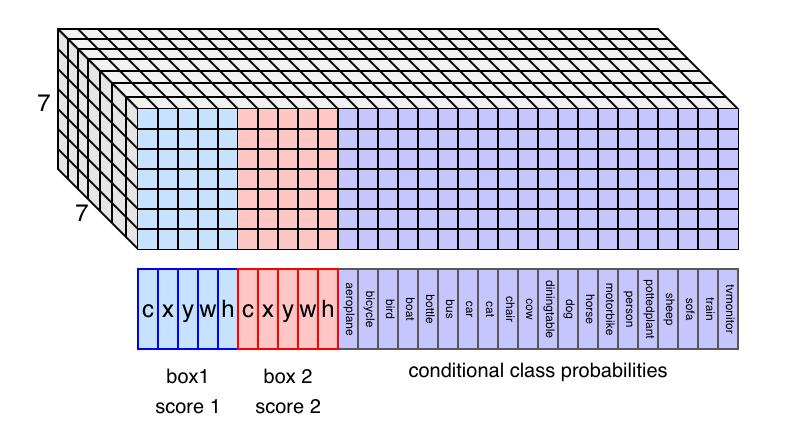

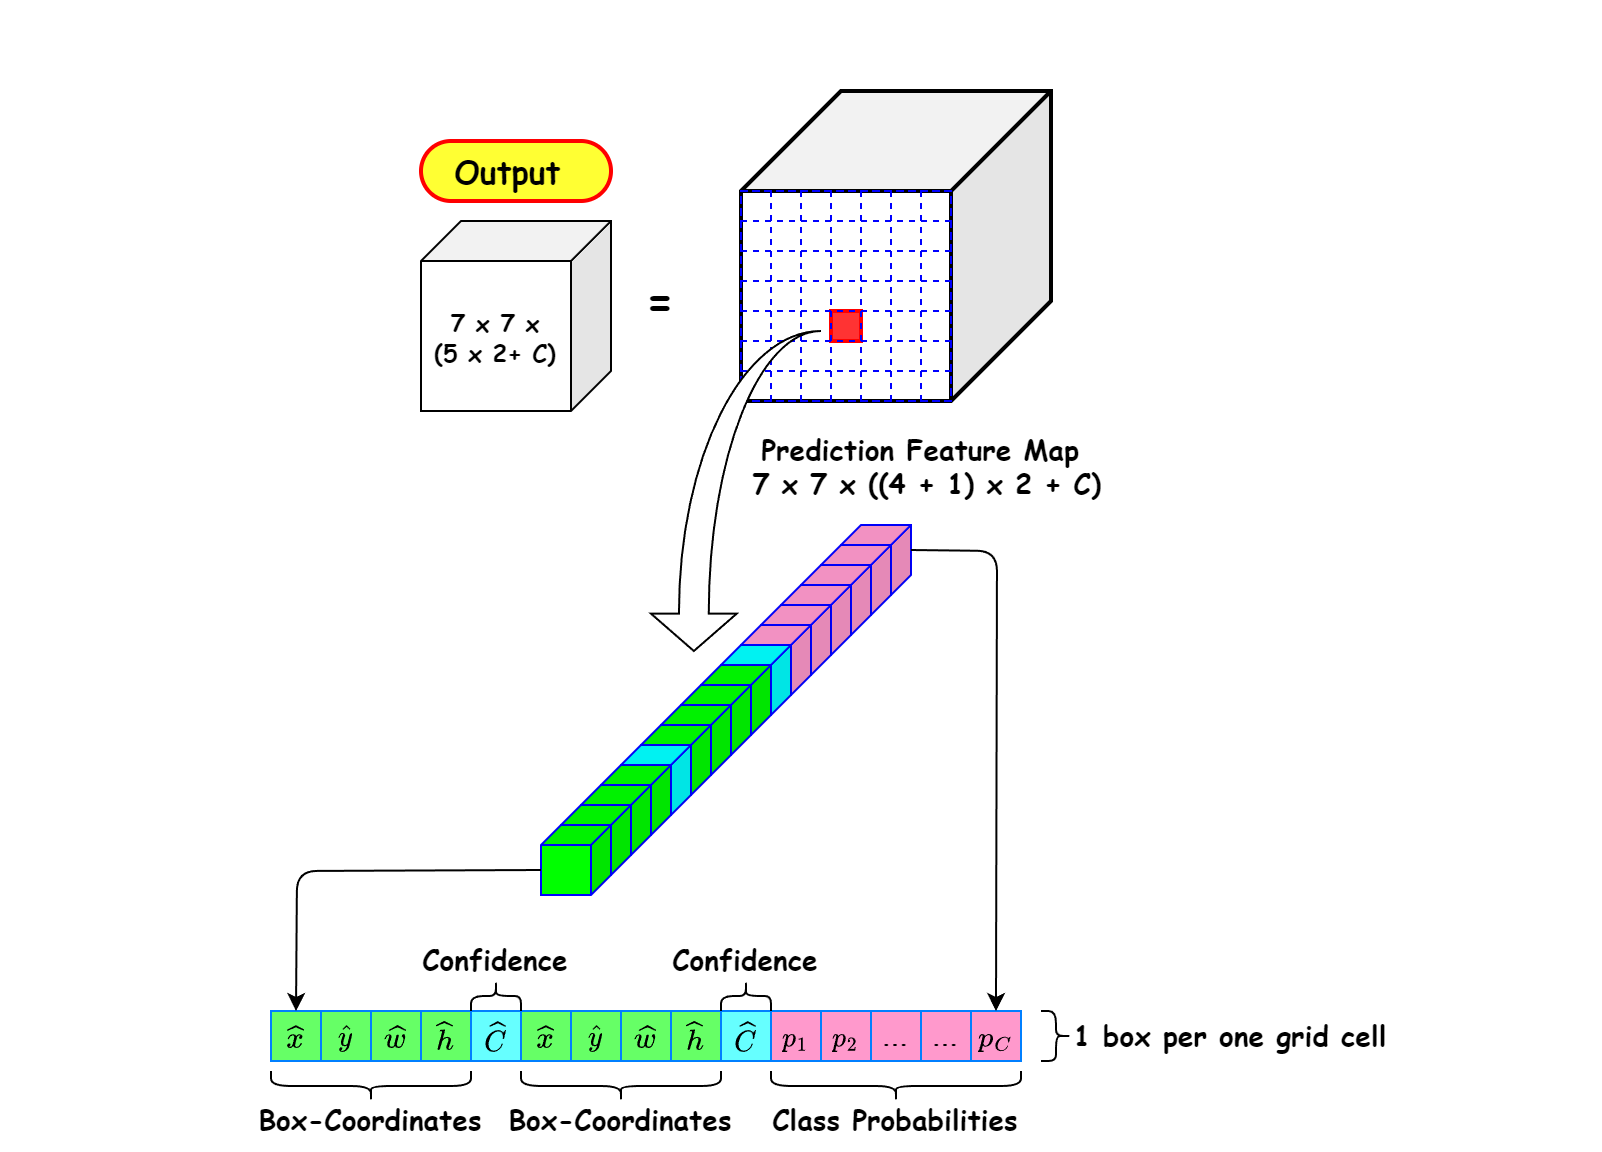

In [5]:
def generate_output(bounding_boxes):
    # Initialize output label tensor
    output_label = np.zeros((SPLIT_SIZE, SPLIT_SIZE, N_CLASSES + 5))

    # Iterate through bounding boxes
    for b in range(len(bounding_boxes)):
        # Calculate grid positions
        grid_x = bounding_boxes[..., b, 0] * SPLIT_SIZE
        grid_y = bounding_boxes[..., b, 1] * SPLIT_SIZE
        
        # Convert to integer grid indices
        i = int(grid_x)
        j = int(grid_y)

        # Assign values to output label tensor
        output_label[i, j, 0:5] = [1., grid_x % 1, grid_y % 1, bounding_boxes[..., b, 2], bounding_boxes[..., b, 3]]
        output_label[i, j, 5 + int(bounding_boxes[..., b, 4])] = 1.

    # Convert output label tensor to TensorFlow tensor
    return tf.convert_to_tensor(output_label, tf.float32)

###### EXAMPLE

In [6]:
bb = preprocess_xml(train_maps+"2007_000032.xml")[0]

print('The 1st bounding box coordinates in the image : ',bb)

print('\nThe grid cell it belongs to : ',int(bb[:1]*SPLIT_SIZE),',',int(bb[1:2]*SPLIT_SIZE))

print('\nThe class of the 1st  bounding box coordinates in the image : ',int(bb[-1]))

print('\nThe normalised height and width of the 1st  bounding box coordinates in the image : ',float(bb[2]),',',float(bb[3]))

print('\n The information of the above in the yolo format \n',generate_output(preprocess_xml(train_maps+"2007_000032.xml"))[3,3])

The 1st bounding box coordinates in the image :  tf.Tensor([0.479      0.4644128  0.542      0.37366548 0.        ], shape=(5,), dtype=float32)

The grid cell it belongs to :  3 , 3

The class of the 1st  bounding box coordinates in the image :  0

The normalised height and width of the 1st  bounding box coordinates in the image :  0.5419999957084656 , 0.3736654818058014

 The information of the above in the yolo format 
 tf.Tensor(
[1.         0.35299993 0.25088978 0.542      0.37366548 1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ], shape=(25,), dtype=float32)


##### GET THE ANNOTATION AND IMAGE FILE PATHS

In [7]:
im_paths=[]
xml_paths=[]

for i in os.listdir(train_maps)[:5000]:
    im_paths.append(train_images+i[:-3]+'jpg')
    xml_paths.append(train_maps+i)

print(len(im_paths),len(xml_paths))

train=tf.data.Dataset.from_tensor_slices((im_paths,xml_paths))

5000 5000


##### GET THE IMAGE AND BOUNDING BOX COORDINATES AND CLASS

In [8]:
images = []

for im_path in im_paths:
    img=cv2.imread(im_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb = img_rgb/255
    img = cv2.resize(img_rgb,(H,W))
    
    images.append(img)
    
images = np.array(images)
    
boxes = []

for xml_path in xml_paths:
    
    boxes.append(generate_output(preprocess_xml(xml_path)))
    
boxes = np.array(boxes)

#### DEFINE THE MODEL AND GET THE WEIGHTS

In [9]:
NUM_FILTERS=512
OUTPUT_DIM=int(N_CLASSES+5)

base_model=tf.keras.applications.ResNet50(
    weights='imagenet',
    input_shape=(H,W,3),
    include_top=False,
)
base_model.trainable=False

In [10]:
model=tf.keras.Sequential([
    base_model,
    Conv2D(NUM_FILTERS,(3,3),padding='same',kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    
    
    Conv2D(NUM_FILTERS,(3,3),padding='same',kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    
    Conv2D(NUM_FILTERS,(3,3),padding='same',kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyReLU(),
    
    Flatten(),
    
    Dense(NUM_FILTERS,kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    
    
    Dense(int(SPLIT_SIZE*SPLIT_SIZE*OUTPUT_DIM),activation='sigmoid'),
    
    Reshape((int(SPLIT_SIZE),int(SPLIT_SIZE),OUTPUT_DIM))
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 512)         9437696   
                                                                 
 batch_normalization (Batch  (None, 7, 7, 512)         2048      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 512)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 512)         2359808   
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 512)         2048      
 chNormalization)                                       

### LOSS FUNCTION

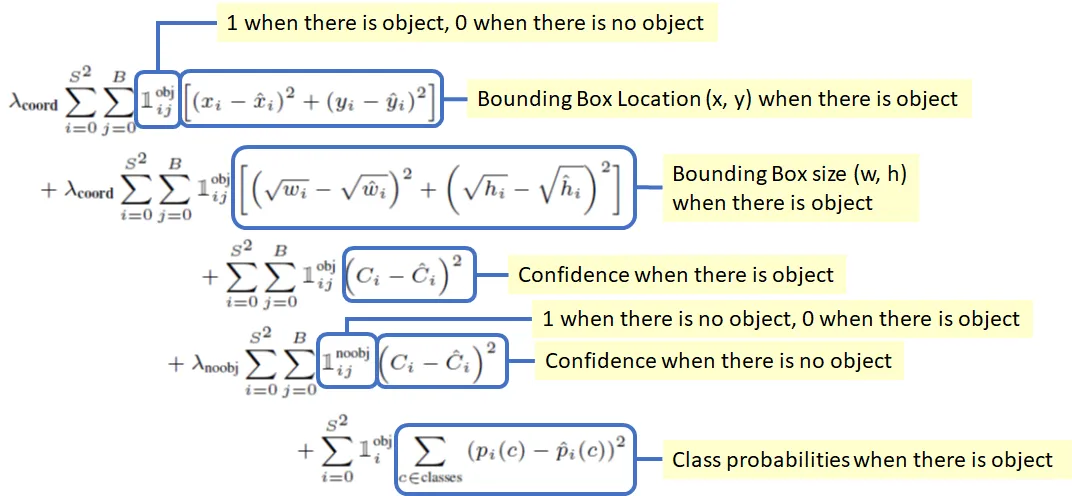

There are 5 terms in the loss function as shown above.

##### 1st term (x, y): 

The bounding box x and y coordinates is parametrized to be offsets of a particular grid cell location so they are also bounded between 0 and 1. And the sum of square error (SSE) is estimated only when there is object.

##### 2nd term (w, h):

The bounding box width and height are normalized by the image width and height so that they fall between 0 and 1. SSE is estimated only when there is object. Since small deviations in large boxes matter less than in small boxes. square root of the bounding box width w and height h instead of the width and height directly to partially address this problem.

##### 3rd term and 4th term (The confidence) (i.e. the IOU between the predicted box and any ground truth box): 

In every image many grid cells do not contain any object. This pushes the “confidence” scores of those cells towards zero, often overpowering the gradient from cells that do contain objects, and makes the model unstable. Thus, the loss from confidence predictions for boxes that don’t contain objects, is decreased, i.e. λnoobj=0.5.

##### 5th term (Class Probabilities): 

SSE of class probabilities when there is objects.
λcoord: Due to the same reason mentioned in 3rd and 4th terms, λcoord = 5 to increase the loss from bounding box coordinate predictions.

In [11]:
def difference(x,y):
    return tf.reduce_sum(tf.square(y-x))

def yolo_loss(y_true,y_pred):
    
    target=y_true[...,0]  # Grid Cell (7x7) where we have information of location of object presence marked as 1 or else 0 when no object is present.
    
    #--------------------------------------- for object
    
    y_pred_extract=tf.gather_nd(y_pred,tf.where(target[:]==1))
    y_target_extract=tf.gather_nd(y_true,tf.where(target[:]==1))
    
    reference=tf.where(target[:]==1)
    
    object_loss=difference(tf.cast(y_pred_extract[...,0],dtype=tf.float32),tf.cast(tf.ones([len(reference)]),dtype=tf.float32))   
    
    #------------------------------------------------------ for no object
    
    y_pred_extract=tf.gather_nd(y_pred[...,0:5],tf.where(target[:]==0))
    y_target_extract=tf.zeros(len(y_pred_extract))

    no_obj_loss=difference(tf.cast(y_pred_extract[...,0],dtype=tf.float32),tf.cast(y_target_extract,dtype=tf.float32))
    
    #-------------------------------------------------------- for object class loss
    
    y_pred_extract=tf.gather_nd(y_pred[...,5:],tf.where(target[:]==1))
    class_extract=tf.gather_nd(y_true[...,5:],tf.where(target[:]==1))
    
    class_loss=difference(tf.cast(y_pred_extract,dtype=tf.float32),tf.cast(class_extract,dtype=tf.float32))
    
    #--------------------------------------------------------- for object center loss
    
    y_pred_extract=tf.gather_nd(y_pred[...,1:3],tf.where(target[:]==1))

    center_target=tf.gather_nd(y_true[...,1:3],tf.where(target[:]==1))
    
    center_loss=difference(tf.cast(y_pred_extract,dtype=tf.float32),tf.cast(center_target,dtype=tf.float32))
    
    
    
    #------------------------------------------------------- for width and height
    
    size_pred=tf.gather_nd(y_pred[...,3:5],tf.where(target[:]==1))
    size_target=tf.gather_nd(y_true[...,3:5],tf.where(target[:]==1))
    
    size_loss=difference(tf.math.sqrt(tf.math.abs(tf.cast(size_pred,dtype=tf.float32))),tf.math.sqrt(tf.math.abs(tf.cast(size_target,dtype=tf.float32))))
    
    
    box_loss=center_loss+size_loss
    
    lambda_coord=5
    lambda_no_obj=0.5
    
    loss=object_loss+(lambda_no_obj*no_obj_loss)+tf.cast(lambda_coord*box_loss,dtype=tf.float32)+tf.cast(class_loss,dtype=tf.float32)
    
    return loss

### TRAIN

In [12]:
def scheduler(epoch, lr):
    if epoch < 20:
        return 1e-3
    elif epoch>=20 and epoch<30:
        return 5e-4
    else:
        return 1e-4

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
model.compile(
  loss=yolo_loss,
  optimizer=tf.keras.optimizers.Adam(1e-3),
)

history = model.fit(images,boxes,
  verbose=1,
  epochs=70,
  callbacks = lr_callback
)

Epoch 1/70


2024-05-13 21:46:16.044218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 44s 272ms/step - loss: 227.8351 - lr: 0.0010
Epoch 2/70
157/157 [==============================] - 41s 260ms/step - loss: 189.4732 - lr: 0.0010
Epoch 3/70
157/157 [==============================] - 42s 269ms/step - loss: 184.4180 - lr: 0.0010
Epoch 4/70
157/157 [==============================] - 44s 279ms/step - loss: 180.5514 - lr: 0.0010
Epoch 5/70
157/157 [==============================] - 42s 271ms/step - loss: 175.1521 - lr: 0.0010
Epoch 6/70
157/157 [==============================] - 45s 284ms/step - loss: 170.6056 - lr: 0.0010
Epoch 7/70
157/157 [==============================] - 43s 273ms/step - loss: 164.9978 - lr: 0.0010
Epoch 8/70
157/157 [==============================] - 43s 276ms/step - loss: 158.9780 - lr: 0.0010
Epoch 9/70
157/157 [==============================] - 43s 271ms/step - loss: 153.1472 - lr: 0.0010
Epoch 10/70
157/157 [==============================] - 46s 293ms/step - loss: 147.7356 - lr: 0.0010
Epoch 11/70
157/157 

### PREDICT AND PLOT FUNCTION

In [21]:
def output_image(image):
    img = image.copy()
    output = model.predict(np.expand_dims(img, axis=0))
    
    # Threshold for detection
    THRESH = 0.25

    object_positions = tf.where(output[..., 0] >= THRESH)
    
    selected_output = tf.gather_nd(output, object_positions)
    
    # Initialize lists for final boxes and scores
    final_boxes = []
    final_scores = []

    # Iterate through object positions
    for i, pos in enumerate(object_positions):

        if selected_output[i][0] > THRESH:
            # Extract box parameters
            output_box = tf.cast(output[pos[0]][pos[1]][pos[2]][1:5], dtype=tf.float32)
            x_centre = (tf.cast(pos[1], dtype=tf.float32) + output_box[0]) * 32
            y_centre = (tf.cast(pos[2], dtype=tf.float32) + output_box[1]) * 32
            x_width, y_height = tf.math.abs(H * output_box[2]), tf.math.abs(W * output_box[3])
            x_min, y_min = int(x_centre - (x_width / 2)), int(y_centre - (y_height / 2))
            x_max, y_max = int(x_centre + (x_width / 2)), int(y_centre + (y_height / 2))

            # Adjust bounding box coordinates
            if x_min <= 0: x_min = 0
            if y_min <= 0: y_min = 0
            if x_max >= W: x_max = W
            if y_max >= H: y_max = H

            # Append to final boxes
            final_boxes.append(
                [x_min, y_min, x_max, y_max, str(classes[tf.argmax(selected_output[..., 5:], axis=-1)[i]])])
            final_scores.append(selected_output[i][0])

    final_boxes = np.array(final_boxes)
    
    # Extract object classes and boxes
    object_classes = final_boxes[..., 4]
    nms_boxes = final_boxes[..., 0:4]

    # Perform non-max suppression
    nms_output = tf.image.non_max_suppression(
        nms_boxes, final_scores, max_output_size=100, iou_threshold=0.2, score_threshold=float('-inf'))

    # Draw bounding boxes and labels on the image
    for i in nms_output:
        cv2.rectangle(img, (int(final_boxes[i][0]), int(final_boxes[i][1])),
                      (int(final_boxes[i][2]), int(final_boxes[i][3])), (0, 0, 255), 1)
        cv2.putText(img, final_boxes[i][-1], (int(final_boxes[i][0]), int(final_boxes[i][1]) + 15),
                    cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (2, 225, 155), 1)

    plt.imshow(img)
    plt.show()

## EXAMPLES

1/1 [==============================] - 0s 28ms/step


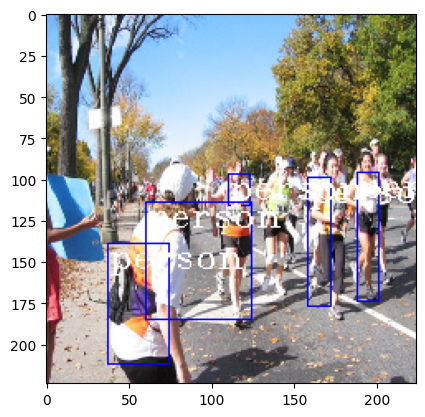

In [40]:
output_image(images[500])

1/1 [==============================] - 0s 34ms/step


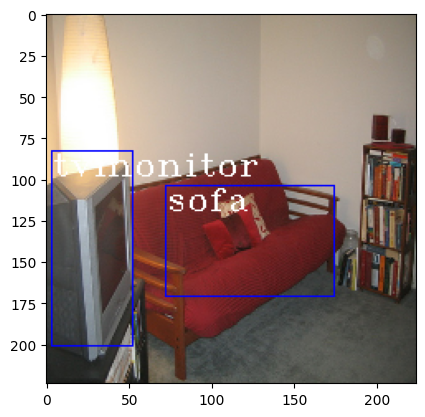

In [41]:
output_image(images[600])

1/1 [==============================] - 0s 35ms/step


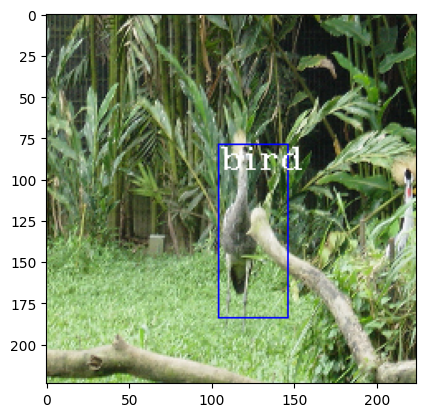

In [43]:
output_image(images[800])

1/1 [==============================] - 0s 34ms/step


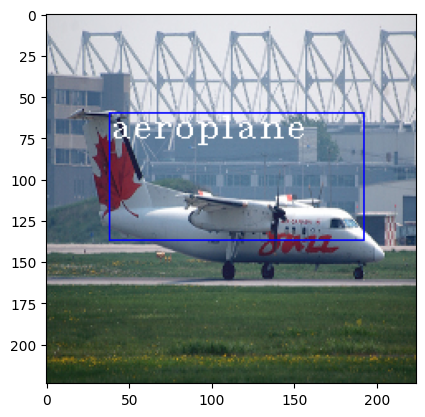

In [45]:
output_image(images[1000])

1/1 [==============================] - 0s 31ms/step


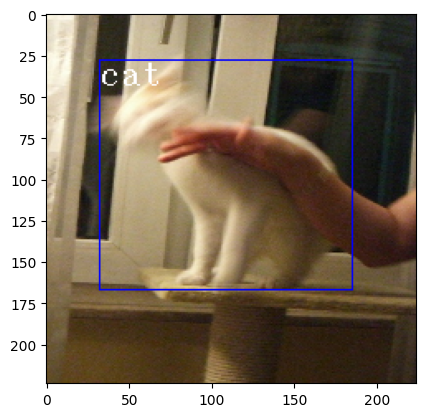

In [46]:
output_image(images[560])

1/1 [==============================] - 0s 32ms/step


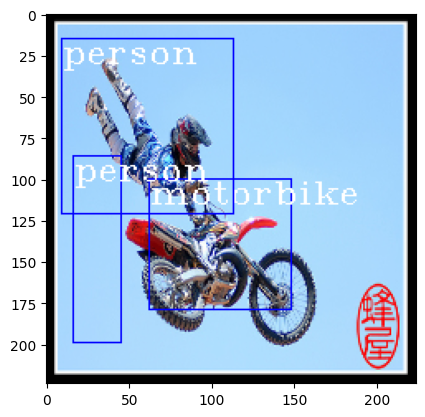

In [48]:
output_image(images[595])

1/1 [==============================] - 0s 31ms/step


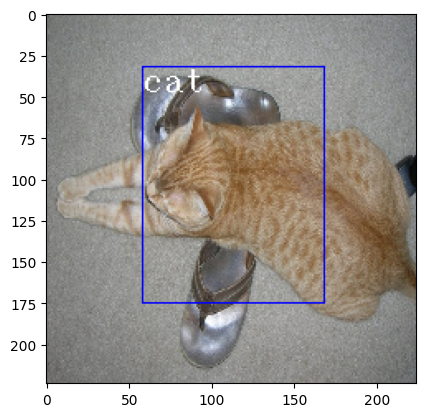

In [49]:
output_image(images[1400])

1/1 [==============================] - 0s 33ms/step


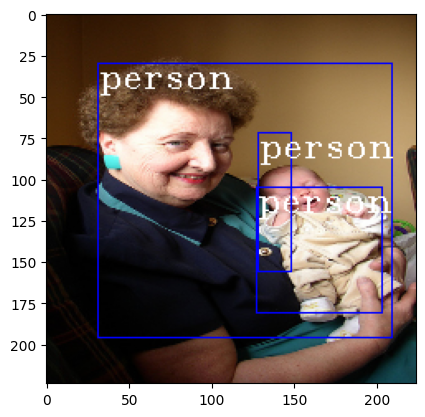

In [50]:
output_image(images[3416])

1/1 [==============================] - 0s 31ms/step


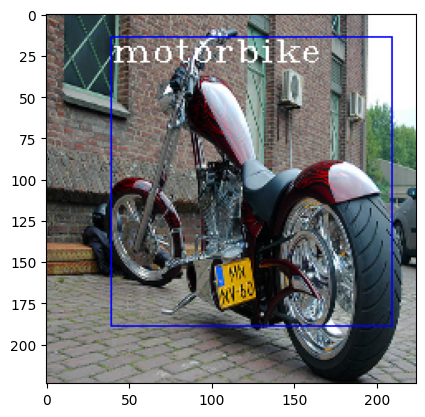

In [63]:
output_image(images[164])

1/1 [==============================] - 0s 33ms/step


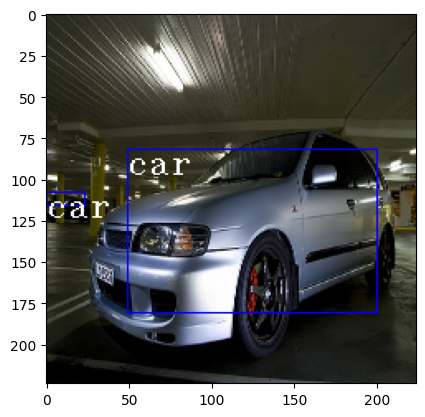

In [71]:
output_image(images[1657])

1/1 [==============================] - 0s 33ms/step


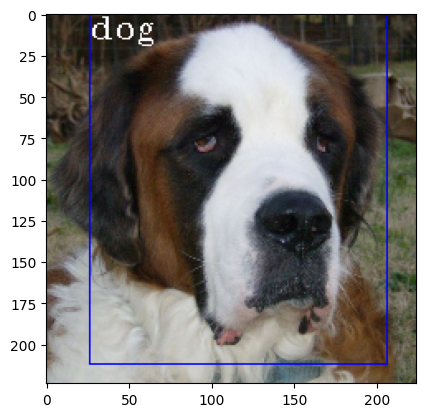

In [92]:
output_image(images[244])

1/1 [==============================] - 0s 30ms/step


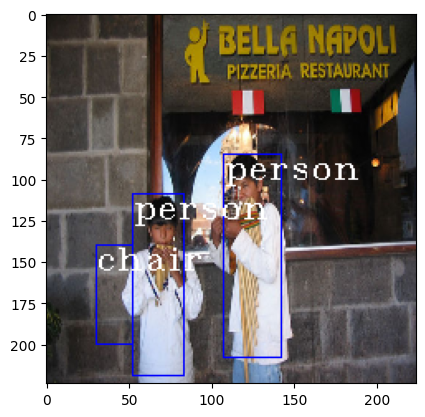

In [96]:
output_image(images[4])

1/1 [==============================] - 0s 31ms/step


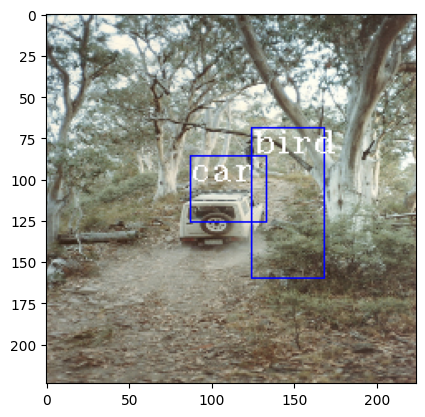

In [104]:
output_image(images[1525])